<a href="https://colab.research.google.com/github/edwin-19/waste_detection/blob/main/DETR_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libs

In [2]:
!pip install transformers
!pip install timm

     |████████████████████████████████| 3.5 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 14.3 MB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
     |████████████████████████████████| 895 kB 38.5 MB/s 
     |████████████████████████████████| 6.5 MB 32.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 431 kB 5.5 MB/s 


In [32]:
import torch
from transformers import DetrForObjectDetection, DetrFeatureExtractor

from matplotlib import pyplot as plt
from PIL import Image
import requests
import numpy as np
import io
import cv2

# Load weights 

In [4]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Downloading:   0%|          | 0.00/274 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [5]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Get data

In [6]:
image = 'https://image.shutterstock.com/image-photo/young-business-man-working-home-260nw-1654831870.jpg'

In [7]:
img_raw = requests.get(image).content
img_pil = Image.open(io.BytesIO(img_raw))

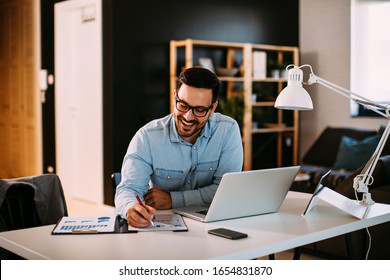

In [8]:
img_pil

# Inference & viz

In [11]:
encoding = feature_extractor(img_pil, return_tensors='pt')
encoding

{'pixel_values': tensor([[[[-1.4843, -1.4843, -1.4843,  ...,  0.5022,  0.5022,  0.5022],
          [-1.4843, -1.4843, -1.4843,  ...,  0.5193,  0.5193,  0.5193],
          [-1.5014, -1.5014, -1.5014,  ...,  0.7419,  0.7419,  0.7419],
          ...,
          [-2.1179, -2.0152, -0.4739,  ...,  2.2489,  2.2489,  2.2489],
          [-2.1179, -2.0152, -0.4739,  ...,  2.2489,  2.2489,  2.2489],
          [-2.1179, -2.0152, -0.4739,  ...,  2.2489,  2.2489,  2.2489]],

         [[-1.6856, -1.6856, -1.6856,  ...,  0.6254,  0.6254,  0.6254],
          [-1.6856, -1.6856, -1.6856,  ...,  0.6429,  0.6429,  0.6429],
          [-1.7031, -1.7031, -1.7031,  ...,  0.8354,  0.8354,  0.8354],
          ...,
          [-2.0357, -1.9307, -0.3550,  ...,  2.4286,  2.4286,  2.4286],
          [-2.0357, -1.9307, -0.3550,  ...,  2.4286,  2.4286,  2.4286],
          [-2.0357, -1.9307, -0.3550,  ...,  2.4286,  2.4286,  2.4286]],

         [[-1.7347, -1.7347, -1.7347,  ...,  0.7576,  0.7576,  0.7576],
          [-1

In [13]:
encoding['pixel_values'].size(), encoding['pixel_mask'].size()

(torch.Size([1, 3, 800, 1114]), torch.Size([1, 800, 1114]))

In [14]:
outputs = model(**encoding)

/usr/local/lib/python3.7/dist-packages/transformers/models/detr/modeling_detr.py:422: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)


# Post processing & viz

In [21]:
probs = outputs.logits.softmax(dim=-1)[0, :, :-1]
keep = probs.max(-1).values >= 0.9

In [27]:
target_sizes = torch.tensor(img_pil.size[::-1]).unsqueeze(0)
postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
bbox_scaled = postprocessed_outputs[0]['boxes'][keep]

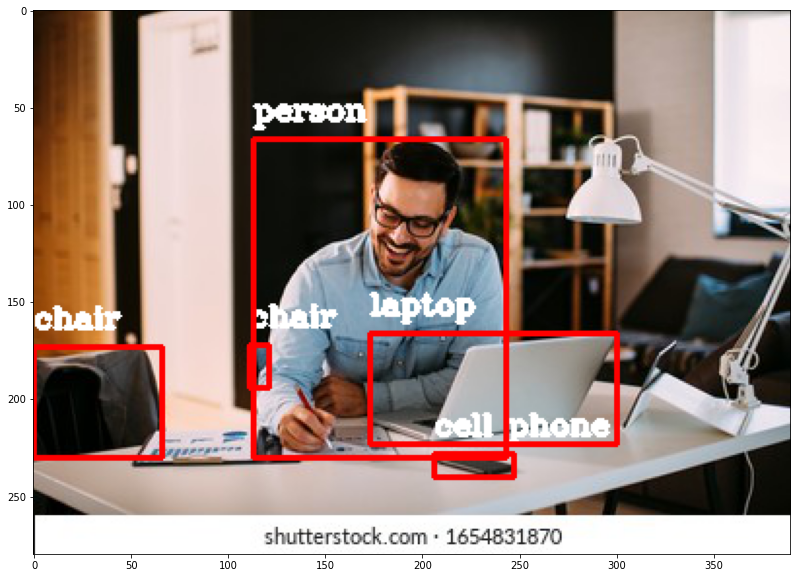

In [45]:
img = np.array(img_pil)
for prob, bb in zip(probs[keep], bbox_scaled.type(torch.int)):
  xmin, ymin, xmax, ymax = bb
  label = model.config.id2label[prob.argmax().item()]
  
  cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255 ,255), 2)
  cv2.rectangle(img, (xmin ,ymin), (xmax, ymax), (255, 0, 0), 2)

plt.figure(figsize=(15, 10))
plt.imshow(img)

# Visualize attention layer

In [46]:
conv_features = []
hooks = [
  model.model.backbone.conv_encoder.register_forward_hook(
      lambda self, input, output: conv_features.append(output)
  ),
]

outputs = model(**encoding, output_attentions=True)

for hook in hooks:
  hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
# get cross-attention weights of last decoder layer - which is of shape (batch_size, num_heads, num_queries, width*height)
dec_attn_weights = outputs.cross_attentions[-1]
# average them over the 8 heads and detach from graph
dec_attn_weights = torch.mean(dec_attn_weights, dim=1).detach()

/usr/local/lib/python3.7/dist-packages/transformers/models/detr/modeling_detr.py:422: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)


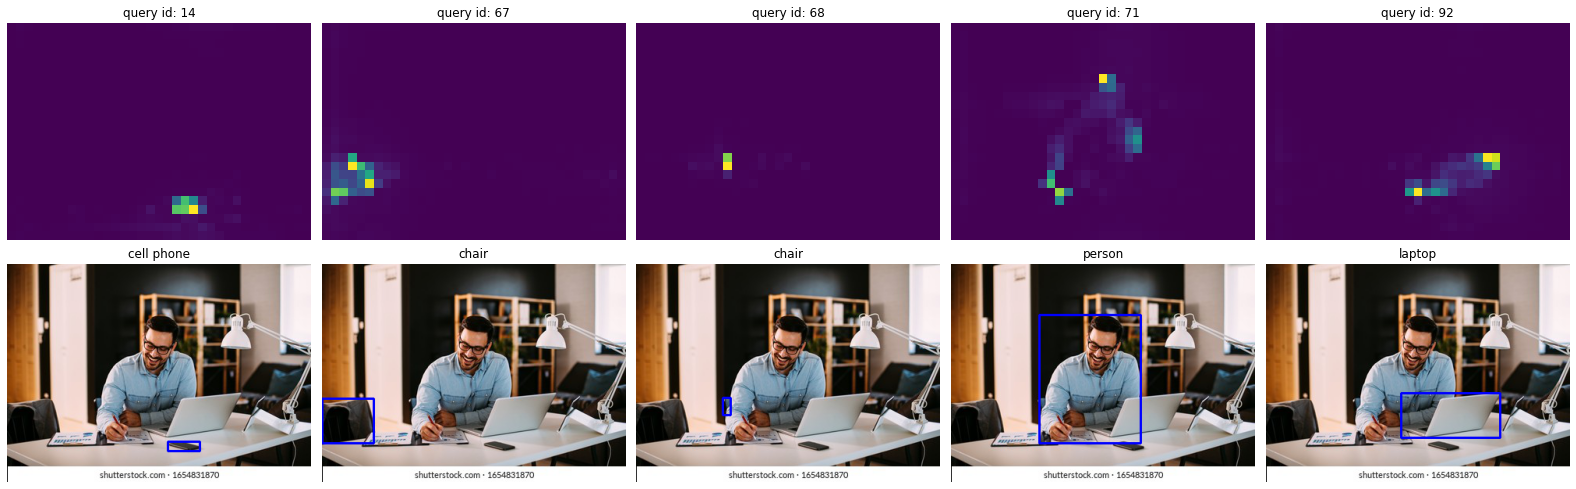

In [54]:
# get the feature map shape
h, w = conv_features[-1][0].shape[-2:]

fig, axs = plt.subplots(ncols=len(bbox_scaled), nrows=2, figsize=(22, 7))
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bbox_scaled):
  ax = ax_i[0]
  ax.imshow(dec_attn_weights[0, idx].view(h, w))
  ax.axis('off')
  ax.set_title(f'query id: {idx.item()}')
  ax = ax_i[1]
  img = np.array(img_pil)
  cv2.rectangle(img, (xmin ,ymin), (xmax, ymax), (0, 0, 255), 2)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(model.config.id2label[probs[idx].argmax().item()])
fig.tight_layout()